##### This IPython Notebook is for integrating filter curves with the spectra to show the Si gap's effect size on tranmission in IR imaging.


Author: Michael Gully-Santiago, `gully@astro.as.utexas.edu`

Date: April 16, 2015

First, let's see if we can get the filter curve data from say... Thorlabs.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

From the Thorlabs website:  
https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=1000

Read in the filter curve, `fc`

In [2]:
fc = pd.read_excel("../data/FB1250-10.xlsx", sheetname='Transmission Data', parse_cols=[2,3,4], skipfooter=2)
fc.tail()

,Wavelength (nm),% Transmission,Optical Density
2396,204,0.000013,6.88533
2397,203,0.000021,6.68095
2398,202,0.000018,6.74232
2399,201,0.000016,6.78794
2400,200,0.000020,6.69023


In [3]:
fc.columns

Index([u'Wavelength (nm)', u'% Transmission', u'Optical Density'], dtype='object')

Normalize the transmission

In [4]:
fc['wavelength'] = fc['Wavelength (nm)']
fc['transmission'] = fc['% Transmission']/fc['% Transmission'].max()

Drop wavelengths shorter than 1200 nm since they are absorbed.

In [5]:
fc.drop(fc.index[fc.wavelength < 1150], inplace=True)

In [6]:
sns.set_context('notebook', font_scale=1.5)

Construct a model.

In [7]:
import etalon as etalon
np.random.seed(78704)

In [8]:
fc.wavelength.values

array([2600, 2599, 2598, ..., 1152, 1151, 1150])

In [9]:
n1 = etalon.sellmeier_Si(fc.wavelength.values)

In [10]:
dsp = etalon.T_gap_Si_fast(fc.wavelength, 0.0, n1)

In [11]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

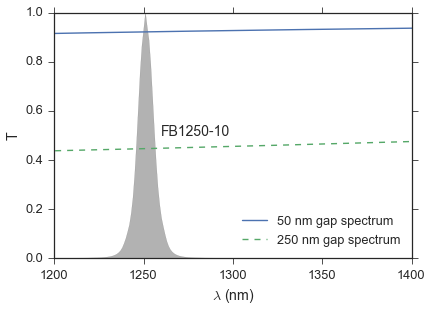

In [12]:
model_absolute = etalon.T_gap_Si_fast(fc.wavelength, 50.0, n1)
model = model_absolute/dsp
plt.plot(fc.wavelength, model,label='50 nm gap spectrum')
model_absolute = etalon.T_gap_Si_fast(fc.wavelength, 250.0, n1)
model = model_absolute/dsp
plt.plot(fc.wavelength, model,'--', label='250 nm gap spectrum')
plt.fill_betweenx(fc.transmission, fc.wavelength, color='k',alpha=0.3)
plt.text(1260, 0.5, 'FB1250-10', fontsize=14)
#plt.plot(fc.wavelength, fc.transmission, '--',label='Filter Curve')
plt.xlabel('$\lambda$ (nm)')
plt.ylabel('T')
plt.legend(loc='lower right')
plt.xlim(1200, 1400)
plt.savefig('../figs/F1250_10_filter.pdf')

Plot the integrated flux for a variety of gap sizes.

Define an integral function.

In [13]:
fc.transmission_norm =  fc.transmission/fc.transmission.sum()
integrate_flux = lambda x: (x * fc.transmission_norm).sum()

Small gaps.

In [14]:
gap_sizes = np.arange(0, 50, 2)
gap_trans = [integrate_flux(etalon.T_gap_Si_fast(fc.wavelength, gap_size, n1)/dsp) for gap_size in gap_sizes]

In [15]:
sns.set_context('paper', font_scale=1.6)
sns.set_style('ticks')

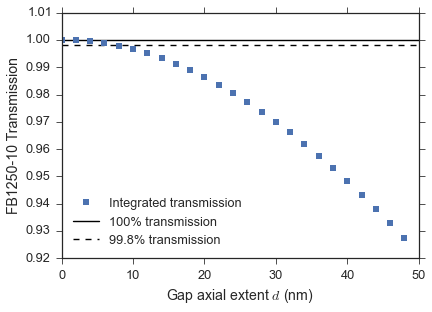

In [16]:
plt.plot(gap_sizes, gap_trans, 's', label='Integrated transmission')
plt.xlabel('Gap axial extent $d$ (nm)')
plt.ylabel('FB1250-10 Transmission')
plt.hlines(1.0, 0, 50, label='100% transmission')
plt.hlines(0.998, 0, 50, linestyle='dashed', label = '99.8% transmission')
plt.legend(loc='lower left')
plt.savefig('../figs/FB1250-10_integ_trans.pdf')

In [17]:
out_tbl = pd.DataFrame({'d (nm)':gap_sizes[::4], 'FB1250-10 Transmission':gap_trans[::4]})
out_tbl['FB1250-10 Transmission'] = out_tbl['FB1250-10 Transmission'].round(3)
out_tbl = out_tbl[['d (nm)','FB1250-10 Transmission']]
out_tbl

,d (nm),FB1250-10 Transmission
0,0,1.000
1,8,0.998
2,16,0.991
3,24,0.981
4,32,0.966
5,40,0.948
6,48,0.928


In [18]:
out_tbl.to_latex('../tbls/tbl_FB1250_raw.tex', index=False)